# Implementação de Multilayer Perceptron (MLP) com NumPy

Este notebook treina uma Multilayer Perceptron (MLP) no dataset Iris. O objetivo é implementar de uma MLP usando apenas NumPy, sem o uso de bibliotecas de aprendizado profundo.

In [1]:
# Importar as bibliotecas
import numpy as np
import matplotlib.pyplot as plt

## Carregamento e Pré-processamento dos Dados
Carregar o dataset Iris e para realizar o pré-processamento necessário, incluindo normalização dos dados e codificação one-hot das classes, que será necessário para esse dataset.

In [2]:
# Carregar o dataset
dataset = np.loadtxt("../Data/iris.data", delimiter=",", dtype=str)

# Separar os dados em features (colunas 0 a 3) e classes (coluna 4)
x = dataset[:, :-1].astype(float)
y = dataset[:, -1]

# Normalizando os dados
x_min = x.min(axis=0)
x_max = x.max(axis=0)
x_normalized = (x - x_min) / (x_max - x_min)

# Convertendo as classes para valores numéricos
u_classes, y_int = np.unique(y, return_inverse=True)

# Dividindo o dataset em treino e teste
np.random.seed(8)
indices = np.arange(x_normalized.shape[0])
np.random.shuffle(indices)

# Separando 70% dos dados para treino e 30% para teste
train_size = int(0.7 * x_normalized.shape[0])
train_indices, test_indices = indices[:train_size], indices[train_size:]

x_train, y_train = x_normalized[train_indices], y_int[train_indices]
x_test, y_test = x_normalized[test_indices], y_int[test_indices]

# Codificação one-hot
def one_hot_encode(y, n_classes):
    return np.eye(n_classes)[y]

# Aplicando a codificação one-hot
n_classes = len(np.unique(y_int))
y_train_one_hot = one_hot_encode(y_train, n_classes)
y_test_one_hot = one_hot_encode(y_test, n_classes)

## Definição das Funções de Ativação

Definir as funções de ativação que serão usadas nas camadas do MLP. A função Sigmoid será usada para as camadas ocultas e a função Linear para a camada de saída.

In [3]:
# Funções de ativação
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def linear(x):
    return x

def linear_derivative(x):
    return 1

## Definição da Classe MLP

Definir a classe `MLP`, que inclui a inicialização, a passagem direta (forward pass), a retropropagação (backward pass com gradiente descendente), e as funções: treinamento, predição e plotagens gráficas.

In [4]:
# Definição da MLP sem Xavier ou Regularização
class MLP:
    # Inicialização da MLP
    def __init__(self, input_tam, ocultas_tam, output_tam):
        self.layers = len(ocultas_tam) + 1
        self.weights = []
        self.biases = []
        self.lossH = []
        self.gradientes = []
        self.activation = []

        # Inicialização dos pesos e bias
        layers_tam = [input_tam] + ocultas_tam + [output_tam]
        for i in range(self.layers):
            self.weights.append(np.random.rand(layers_tam[i], layers_tam[i + 1]) * 0.1)
            self.biases.append(np.zeros((1, layers_tam[i + 1])))
    
    # Forward pass
    def forward(self, x):
        self.a = [x]
        self.z = []

        for i in range(self.layers):
            # z = a * w + b
            self.z.append(np.dot(self.a[i], self.weights[i]) + self.biases[i])
            
            # Aplicações das funções de ativação
            if i == self.layers - 1:
                # Última camada é linear
                self.a.append(linear(self.z[i]))
            else:
                # Camadas ocultas são sigmoid
                self.a.append(sigmoid(self.z[i]))
        
        return self.a[-1]
    
    # Backward pass (gradiente descendente)
    def backward(self, x, y, lr):
        # Cálculo do erro na última camada
        error = self.a[-1] - y
        gradientes = [error * linear_derivative(self.a[-1])]

        # Backpropagation das camadas ocultas
        for i in range(self.layers - 1, 0, -1):
            error = np.dot(gradientes[0], self.weights[i].T)
            gradientes.insert(0, error * sigmoid_derivative(self.a[i]))

        # Atualização dos pesos e bias
        for i in range(self.layers):
            self.weights[i] -= lr * np.dot(self.a[i].T, gradientes[i])
            self.biases[i] -= lr * np.sum(gradientes[i], axis=0, keepdims=True)
    
        return gradientes
        
    # Treinamento da MLP
    def train(self, x, y, epochs, lr):
        for epoch in range(epochs):
            output = self.forward(x)

            # Sinalizador de NaN ou Inf
            if np.any(np.isnan(output)) or np.any(np.isinf(output)):
                print(f"NaN ou Inf detectado na época {epoch}")
                break

            loss = np.mean((output - y) ** 2)
            self.lossH.append(loss)
            gradiente = self.backward(x, y, lr)

            if (epoch + 1) % 100 == 0 or epoch == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss}")
                self.gradientes.append(gradiente)
                self.activation.append([a.copy() for a in self.a])

    # Predição
    def predict(self, x):
        return self.forward(x)
    
    # Plotar o gráfico da função de perda
    def plot_loss(self):
        plt.plot(self.lossH)
        plt.xlabel("Época")
        plt.ylabel("Erro")
        plt.title("Função de Perda da MLP")
        plt.show()

    # Plotar ativações
    def plot_activations(self):
        if not self.activation:
            print("Nenhuma ativação armazenada.")
            return
        num_layers = len(self.activation[0])
        for i in range(num_layers):
            plt.figure(figsize=(10, 4))
            for epoch in range(len(self.activation)):
                if epoch == 0:
                    plt.hist(self.activation[epoch][i].flatten(), bins=30, alpha=0.5, label=f'Época {epoch + 1}')
                else:
                    plt.hist(self.activation[epoch][i].flatten(), bins=30, alpha=0.5, label=f'Época {epoch * 100}')
            if i == 0:
                plt.title(f'Ativações da camada de entrada')
            elif i == num_layers - 1:
                plt.title(f'Ativações da camada de saída')
            else:
                plt.title(f'Ativações da camada oculta {i} ({i} de {num_layers - 2})')
            plt.xlabel('Valor da Ativação')
            plt.ylabel('Frequência')
            plt.legend()
            plt.show()
    
    # Plotar gradientes
    def plot_gradientes(self):
        if not self.gradientes:
            print("Nenhum gradiente foi armazenado")
            return
        num_layers = len(self.gradientes[0])
        for i in range(num_layers):
            plt.figure(figsize=(10, 5))
            for epoch in range(len(self.gradientes)):
                if epoch == 0:
                    plt.plot(self.gradientes[epoch][i].flatten(), label=f'Época {epoch + 1}')
                else:
                    plt.plot(self.gradientes[epoch][i].flatten(), label=f'Época {epoch * 100}')
            if i == 0:
                plt.title(f'Gradientes da camada de entrada')
            elif i == num_layers - 1:
                plt.title(f'Gradientes da camada de saída')
            else:
                plt.title(f'Gradientes da camada oculta {i} ({i} de {num_layers - 2})')
            plt.xlabel('Índice do Gradiente')
            plt.ylabel('Valor do Gradiente')
            plt.legend()
            plt.show()   

## Criação e Treinamento da MLP

Criar a MLP no dataset Iris e treiná-la, monitorando a função de perda ao longo das épocas.


In [5]:
# Criação da MLP
input_tam = x_train.shape[1]
ocultas_tam = [2, 4]
output_tam = n_classes
mlp = MLP(input_tam, ocultas_tam, output_tam)

# Treinamento da MLP
mlp.train(x_train, y_train_one_hot, epochs=1000, lr=0.01)

Epoch 1, Loss: 0.28334745196002853
Epoch 100, Loss: 0.2205671902604183
Epoch 200, Loss: 0.22052810364193615
Epoch 300, Loss: 0.22040959006753721
Epoch 400, Loss: 0.2198251944797561
Epoch 500, Loss: 0.2117513185099988
Epoch 600, Loss: 0.10562250763626084
Epoch 700, Loss: 0.1041731983629729
Epoch 800, Loss: 0.10391862761508842
Epoch 900, Loss: 0.10369044524063045
Epoch 1000, Loss: 0.10343444059931983


## Avaliação do Modelo

Avaliar o desempenho do modelo no conjunto de teste e calcular a acurácia.


In [6]:
# Fazendo previsões
y_pred = mlp.predict(x_test)

y_pred_classe = np.argmax(y_pred, axis=1)
y_true_classe = np.argmax(y_test_one_hot, axis=1)

# Acurácia
accuracy = np.mean(y_pred_classe == y_true_classe)
print(f"Acurácia no conjunto de teste: {accuracy * 100:.2f}%")

Acurácia no conjunto de teste: 60.00%


## Visualização gráfica

Plotar a função de perda ao longo das épocas, assim como ativações e gradientes, para visualizar o processo de treinamento.


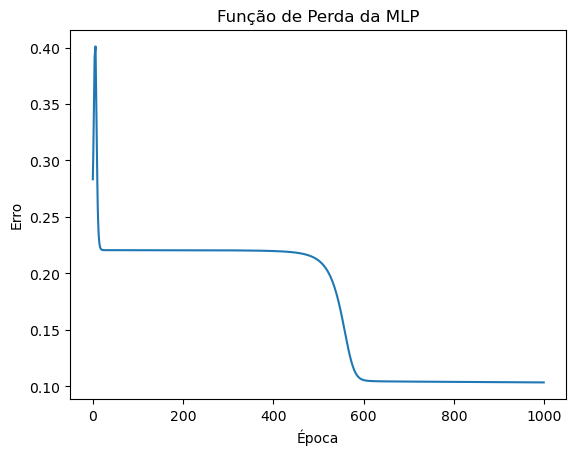

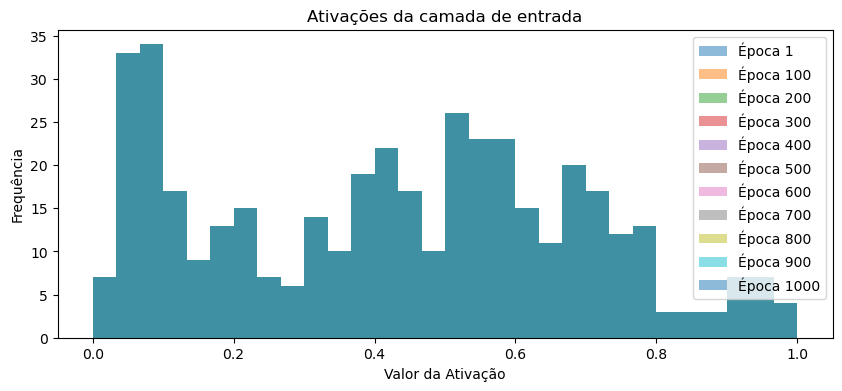

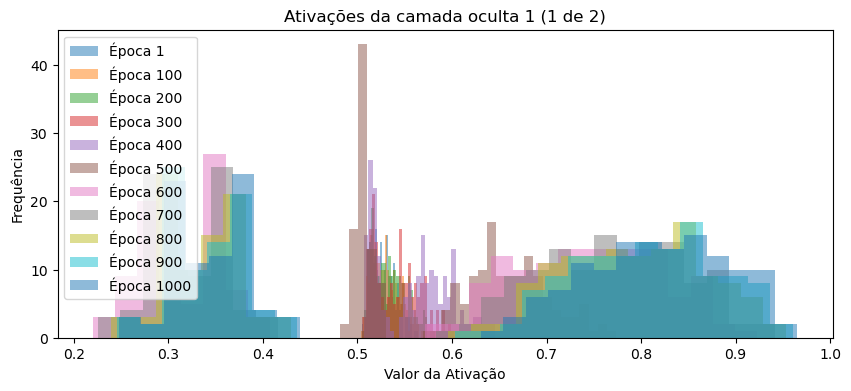

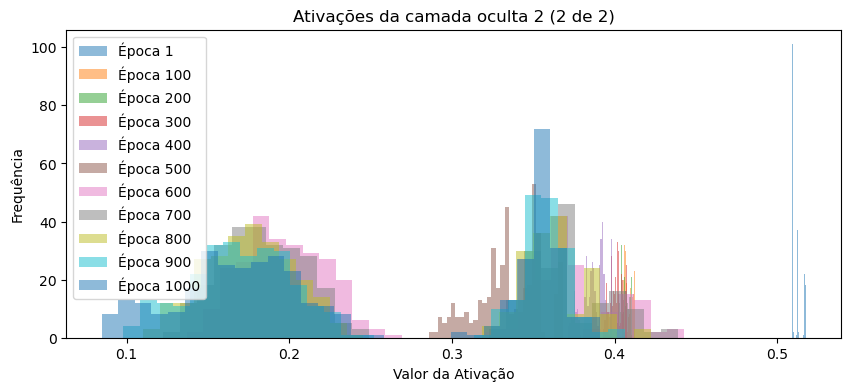

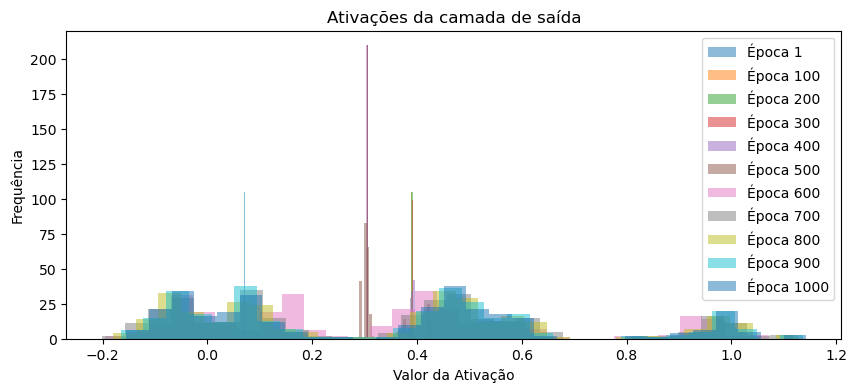

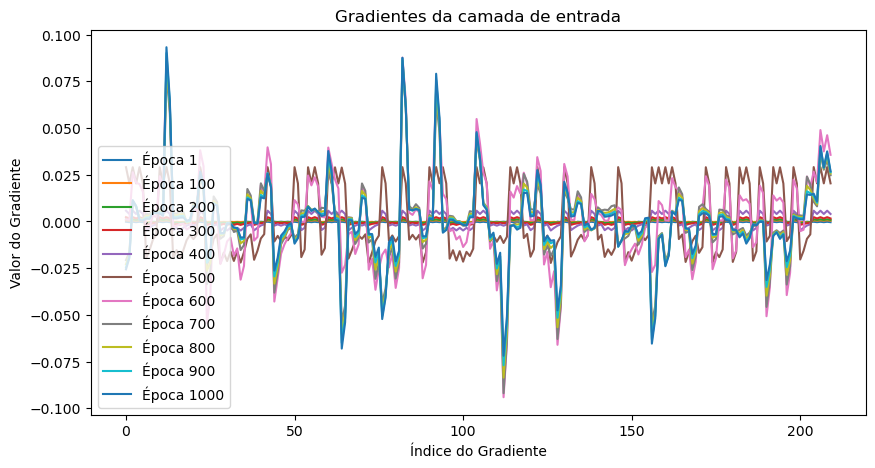

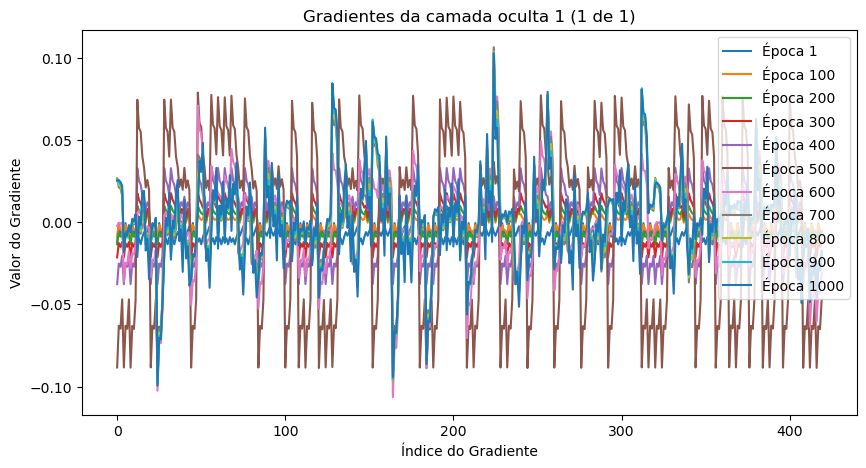

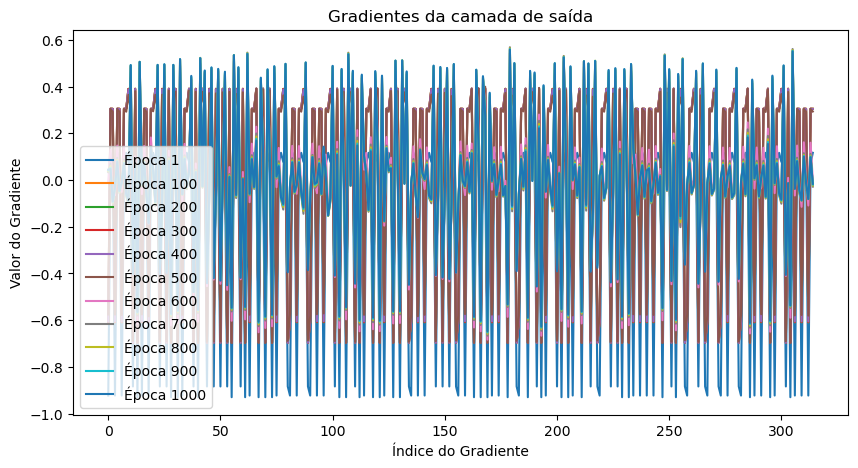

In [7]:
# Plotando a curva de perda
mlp.plot_loss()

# Plotando as ativações
mlp.plot_activations()

# Plotando os gradientes
mlp.plot_gradientes()

### Observação

O modelo não apresenta uma performance boa, ou devido as inicializações dos pesos ou devido as camadas.

## Mudança na Criação da MLP

Realizar o mesmo processo ao criar a `MLP`, porém com mais camadas para analisarmos a diferença.

Epoch 1, Loss: 0.24847674640558948
Epoch 100, Loss: 0.22058978036912155
Epoch 200, Loss: 0.22058977457856152
Epoch 300, Loss: 0.22058976883640316
Epoch 400, Loss: 0.22058976314128695
Epoch 500, Loss: 0.22058975749186732
Epoch 600, Loss: 0.22058975188681118
Epoch 700, Loss: 0.2205897463247985
Epoch 800, Loss: 0.22058974080452123
Epoch 900, Loss: 0.2205897353246833
Epoch 1000, Loss: 0.22058972988400036
Acurácia no conjunto de teste: 20.00%


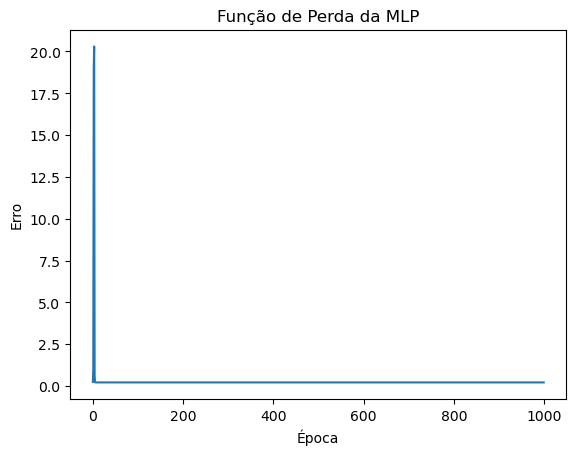

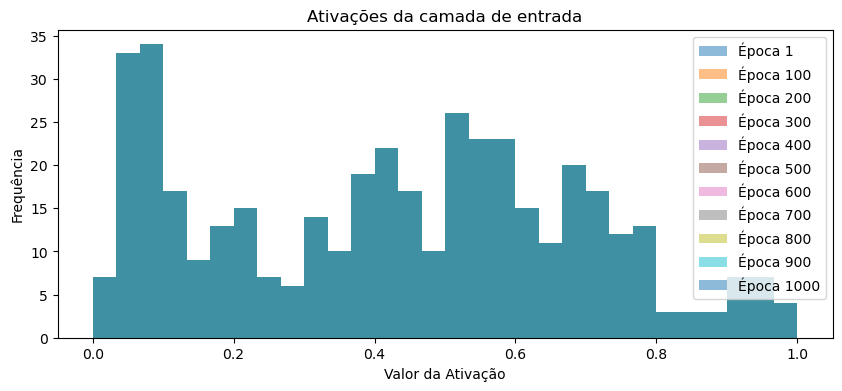

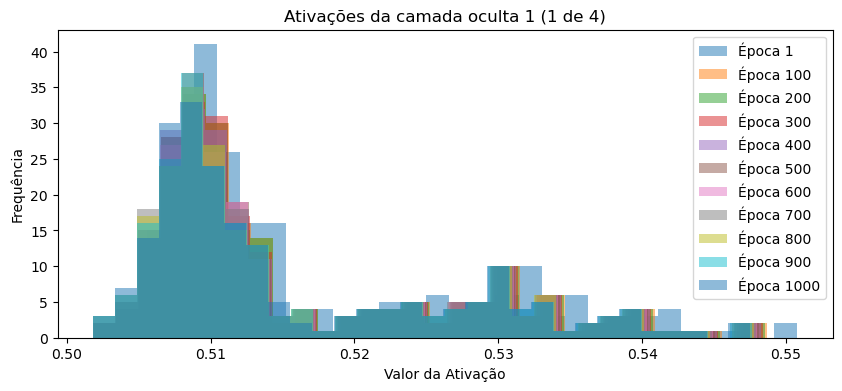

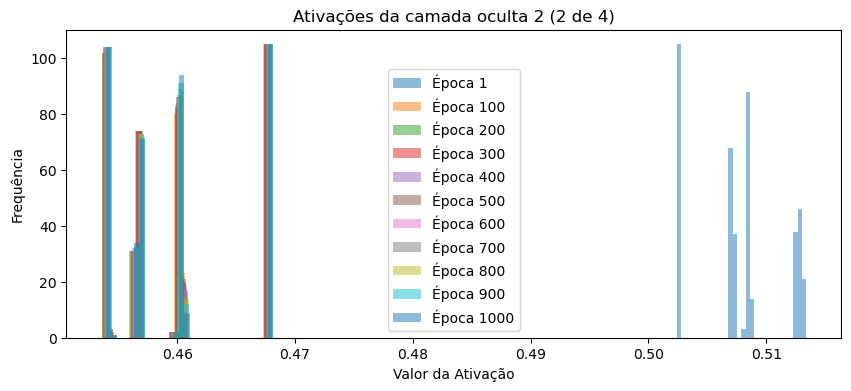

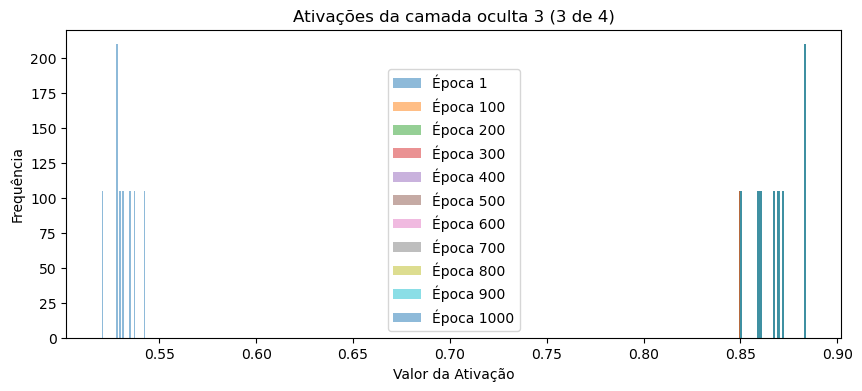

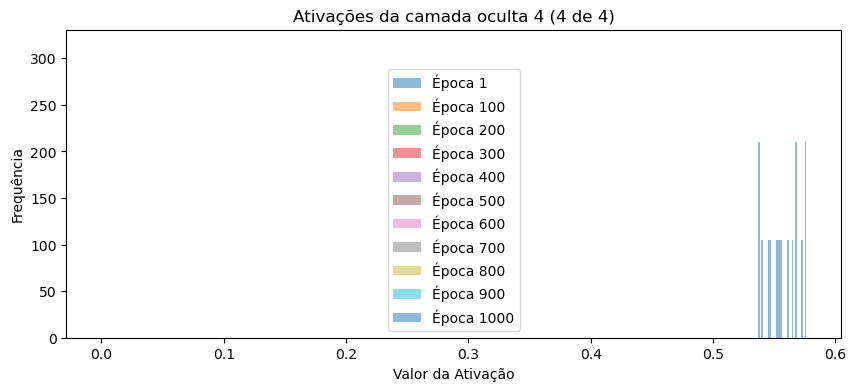

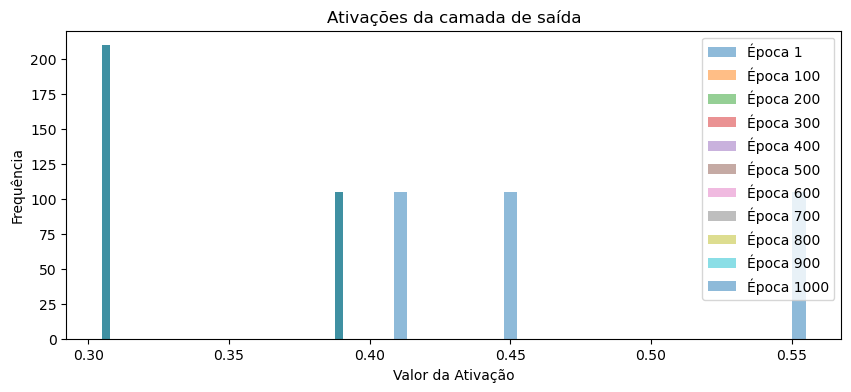

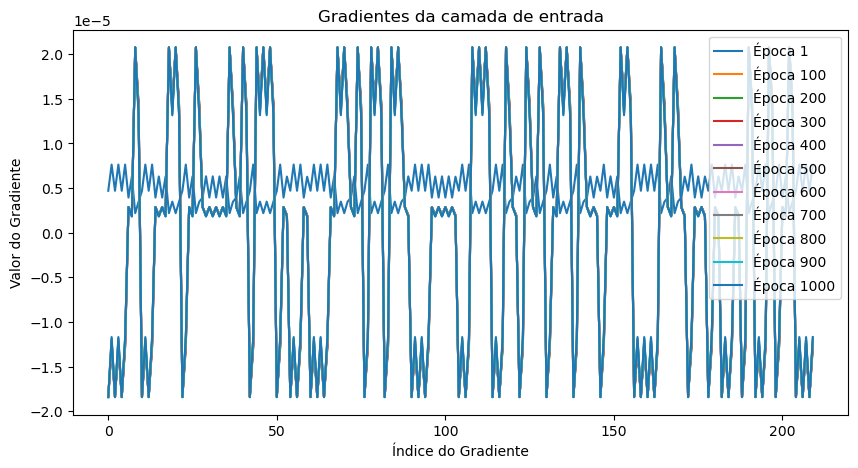

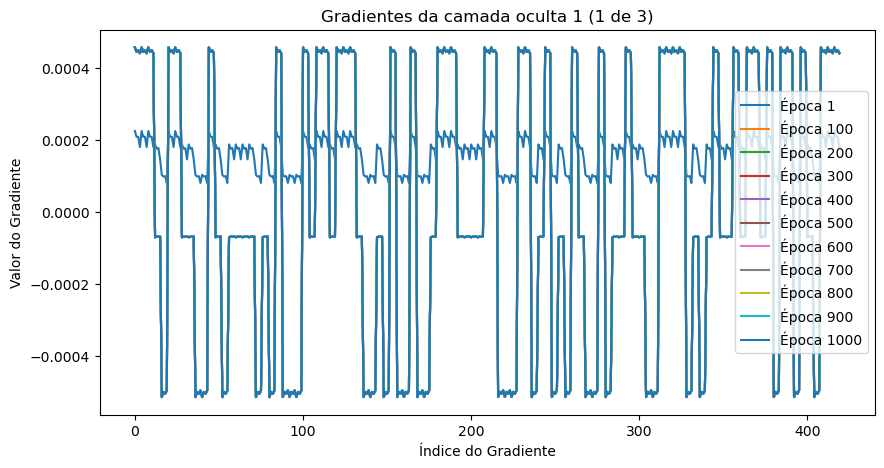

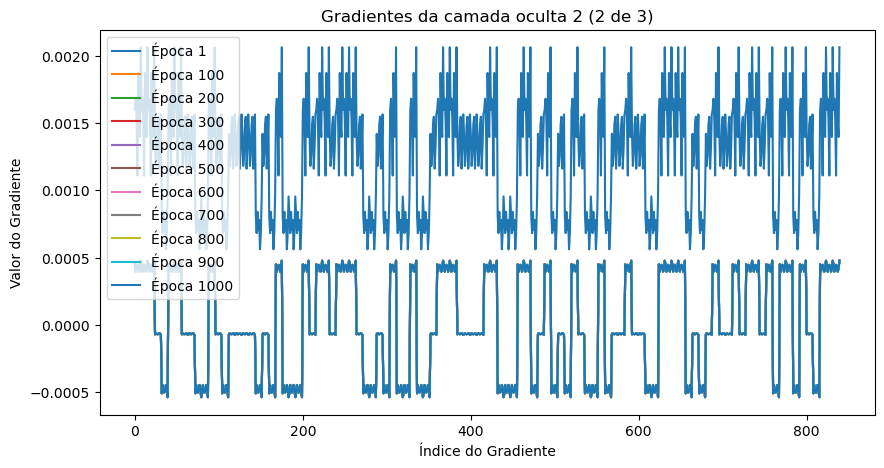

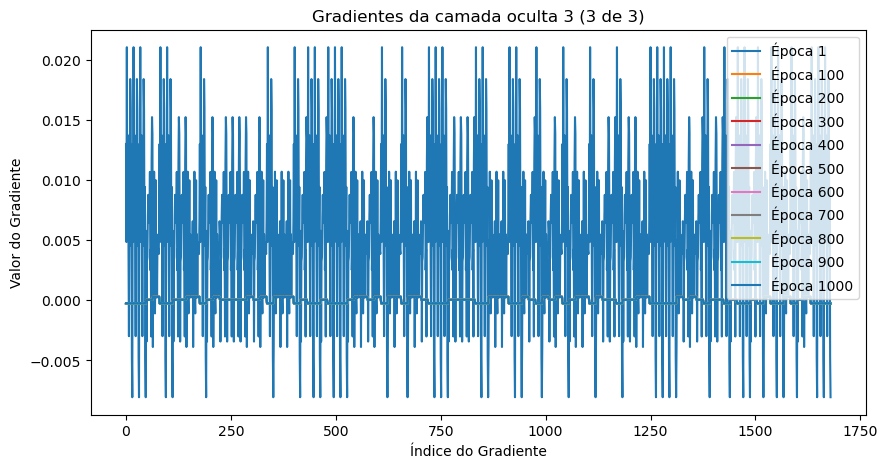

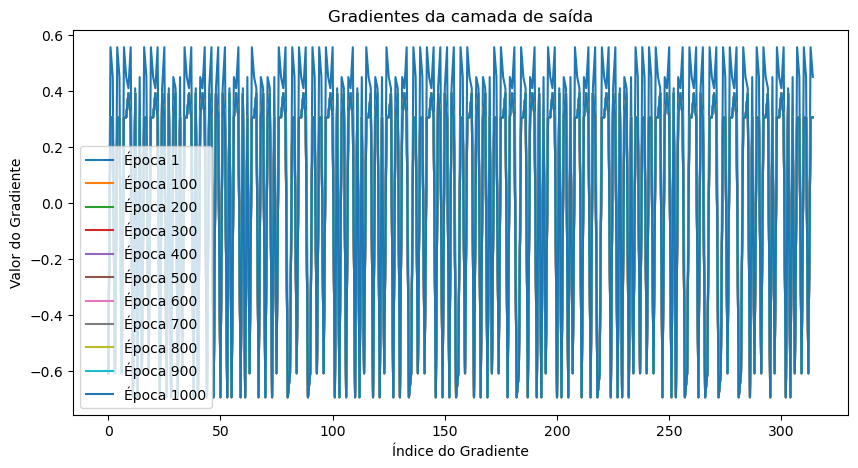

In [8]:
# Criação da MLP com mais camadas
input_tam = x_train.shape[1]
ocultas_tam = [2, 4, 8, 16]
output_tam = n_classes
mlp = MLP(input_tam, ocultas_tam, output_tam)

# Treinamento da MLP
mlp.train(x_train, y_train_one_hot, epochs=1000, lr=0.01)

# Fazendo previsões
y_pred = mlp.predict(x_test)

y_pred_classe = np.argmax(y_pred, axis=1)
y_true_classe = np.argmax(y_test_one_hot, axis=1)

# Acurácia
accuracy = np.mean(y_pred_classe == y_true_classe)
print(f"Acurácia no conjunto de teste: {accuracy * 100:.2f}%")

# Plotando a curva de perda
mlp.plot_loss()

# Plotando as ativações
mlp.plot_activations()

# Plotando os gradientes
mlp.plot_gradientes()

### Observação

O aumento no número de camadas reduz a performace do modelo, logo devemos focar em fazer uma boa inicialização dos pesos.

## Inicialização dos Pesos

Implementar a inicialização de Xavier para os pesos da MLP, o que ajuda a manter a variância dos valores de saída de cada camada aproximadamente constante.


In [9]:
# Função de inicialização de Xavier
def xavier_init(size):
    dimen = size[0]
    xavier_padr = np.sqrt(2.0 / (dimen + size[1]))
    return np.random.randn(*size) * xavier_padr

## Definição da Classe MLPX

Definir uma nova classe `MLPX`, que é a classe `MLP` adjunta da inicialização de Xavier e uma Regularização L2 (modificações na `def _init_`, na `def backward` na `def train`).

In [10]:
# Definição da MLP com Xavier e Regularização L2
class MLPX:
    # Inicialização da MLP
    def __init__(self, input_tam, ocultas_tam, output_tam, lambda_l2 = 0.01):
        self.layers = len(ocultas_tam) + 1
        self.weights = []
        self.biases = []
        self.lossH = []
        self.gradientes = []
        self.activations = []
        self.lambda_l2 = lambda_l2

        # Inicialização dos pesos e bias usando Xavier
        layers_tam = [input_tam] + ocultas_tam + [output_tam]
        for i in range(self.layers):
            self.weights.append(xavier_init((layers_tam[i], layers_tam[i + 1])))
            self.biases.append(np.zeros((1, layers_tam[i + 1])))
    
    # Forward pass
    def forward(self, x):
        self.a = [x]
        self.z = []

        for i in range(self.layers):
            # z = a * w + b
            self.z.append(np.dot(self.a[i], self.weights[i]) + self.biases[i])
            
            # Aplicações das funções de ativação
            if i == self.layers - 1:
                # Última camada é linear
                self.a.append(linear(self.z[i]))
            else:
                # Camadas ocultas são sigmoid
                self.a.append(sigmoid(self.z[i]))
        
        return self.a[-1]
    
    # Backward pass (gradiente descendente)
    def backward(self, x, y, lr):
        # Cálculo do erro na última camada
        error = self.a[-1] - y
        gradientes = [error * linear_derivative(self.a[-1])]

        # Backpropagation das camadas ocultas
        for i in range(self.layers - 1, 0, -1):
            error = np.dot(gradientes[0], self.weights[i].T)
            gradientes.insert(0, error * sigmoid_derivative(self.a[i]))

        # Atualização dos pesos e bias
        for i in range(self.layers):
            self.weights[i] -= lr * (np.dot(self.a[i].T, gradientes[i]) + self.lambda_l2 * self.weights[i])
            self.biases[i] -= lr * np.sum(gradientes[i], axis=0, keepdims=True)
        
        return gradientes
    
    # Treinamento da MLP
    def train(self, x, y, epochs, lr):
        for epoch in range(epochs):
            output = self.forward(x)

            # Sinalizador de NaN ou Inf
            if np.any(np.isnan(output)) or np.any(np.isinf(output)):
                print(f"NaN ou Inf detectado na época {epoch}")
                break

            loss = np.mean((output - y) ** 2) + self.lambda_l2 * sum(np.sum(w ** 2) for w in self.weights)
            self.lossH.append(loss)
            gradientes = self.backward(x, y, lr)

            if (epoch + 1) % 100 == 0 or epoch == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss}")
                self.gradientes.append(gradientes)
                self.activations.append([a.copy() for a in self.a])
    
    # Predição
    def predict(self, x):
        return self.forward(x)
    
    # Plotar o gráfico da função de perda
    def plot_loss(self):
        plt.plot(self.lossH)
        plt.xlabel("Época")
        plt.ylabel("Erro")
        plt.title("Função de Perda da MLP")
        plt.show()
    
    # Plotar ativações
    def plot_activations(self):
        if not self.activations:
            print("Nenhuma ativação armazenada.")
            return
        num_layers = len(self.activations[0])
        for i in range(num_layers):
            plt.figure(figsize=(10, 4))
            for epoch in range(len(self.activations)):
                if epoch == 0:
                    plt.hist(self.activations[epoch][i].flatten(), bins=30, alpha=0.5, label=f'Época {epoch + 1}')
                else:
                    plt.hist(self.activations[epoch][i].flatten(), bins=30, alpha=0.5, label=f'Época {epoch * 100}')
            if i == 0:
                plt.title(f'Ativações da camada de entrada')
            elif i == num_layers - 1:
                plt.title(f'Ativações da camada de saída')
            else:
                plt.title(f'Ativações da camada oculta {i} ({i} de {num_layers - 2})')
            plt.xlabel('Valor da Ativação')
            plt.ylabel('Frequência')
            plt.legend()
            plt.show()

    # Plotar gradientes
    def plot_gradientes(self):
        if not self.gradientes:
            print("Nenhum gradiente armazenado.")
            return
        num_layers = len(self.gradientes[0])
        for i in range(num_layers):
            plt.figure(figsize=(10, 4))
            for epoch in range(len(self.gradientes)):
                if epoch == 0:
                    plt.plot(self.gradientes[epoch][i].flatten(), label=f'Época {epoch + 1}')
                else:
                    plt.plot(self.gradientes[epoch][i].flatten(), label=f'Época {epoch * 100}')
            if i == 0:
                plt.title(f'Gradientes da camada de entrada')
            elif i == num_layers - 1:
                plt.title(f'Gradientes da camada de saída')
            else:
                plt.title(f'Gradientes da camada oculta {i} ({i} de {num_layers - 2})')
            plt.xlabel('Índice do Gradiente')
            plt.ylabel('Valor do Gradiente')
            plt.legend()
            plt.show()

## Criação da MLPX

Realizar o mesmo processo da criação da `MLP` para a `MLPX`.

Epoch 1, Loss: 0.582399951777752
Epoch 100, Loss: 0.33649528916101634
Epoch 200, Loss: 0.4069802430622648
Epoch 300, Loss: 0.41921212060533264
Epoch 400, Loss: 0.43943452215964324
Epoch 500, Loss: 0.4533459516874996
Epoch 600, Loss: 0.4786672678098628
Epoch 700, Loss: 0.5333684447906454
Epoch 800, Loss: 0.6556894301810718
Epoch 900, Loss: 0.893336304945255
Epoch 1000, Loss: 1.0824529055036987
Acurácia no conjunto de teste: 93.33%


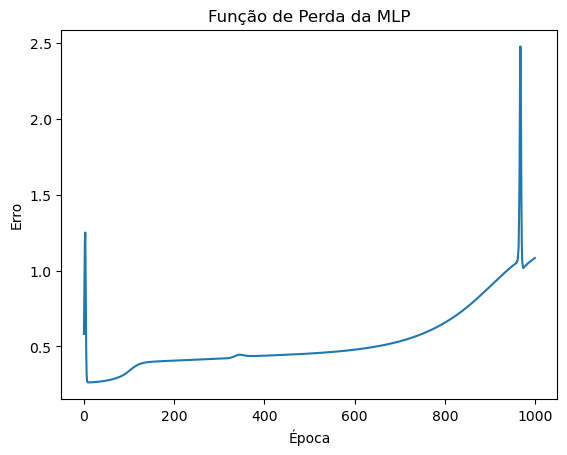

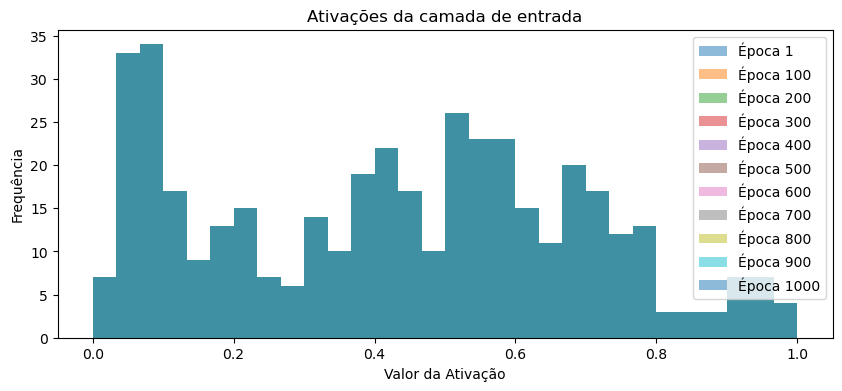

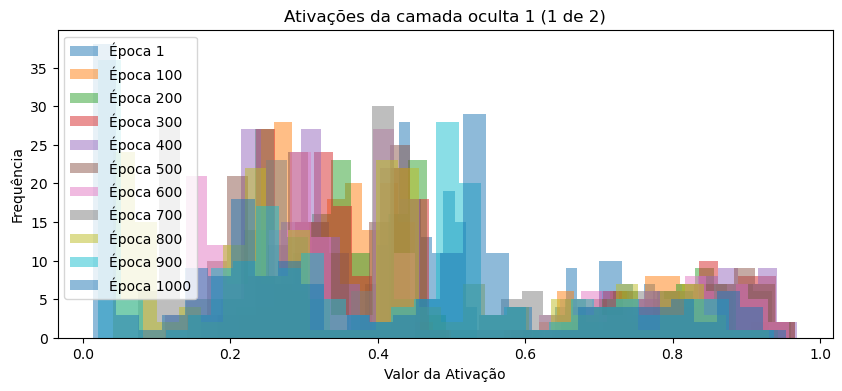

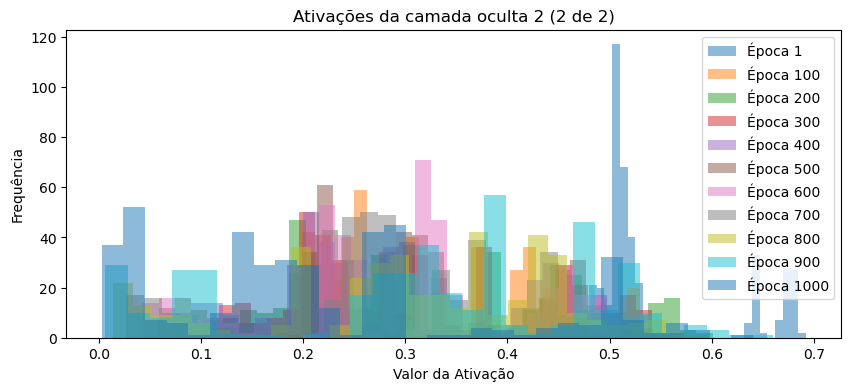

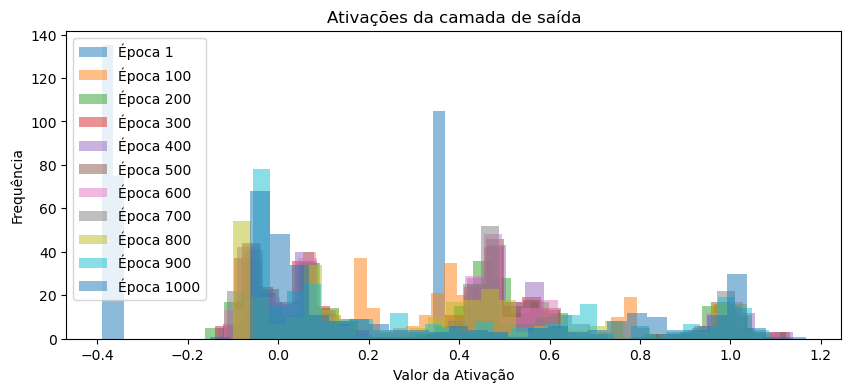

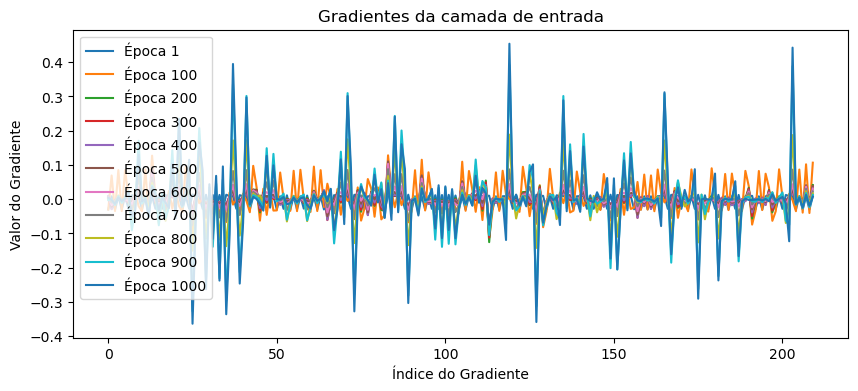

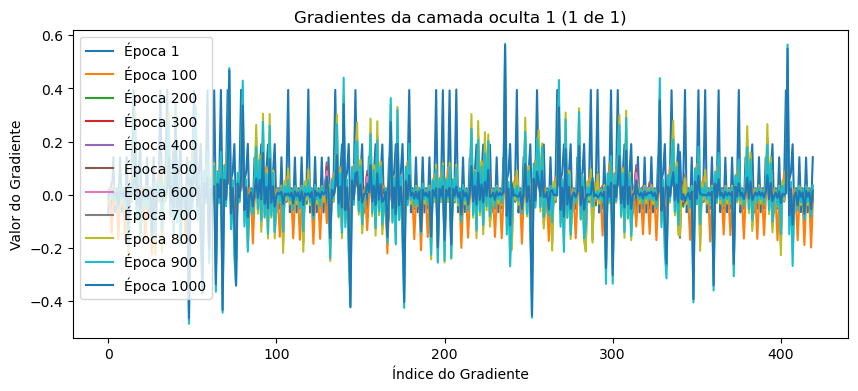

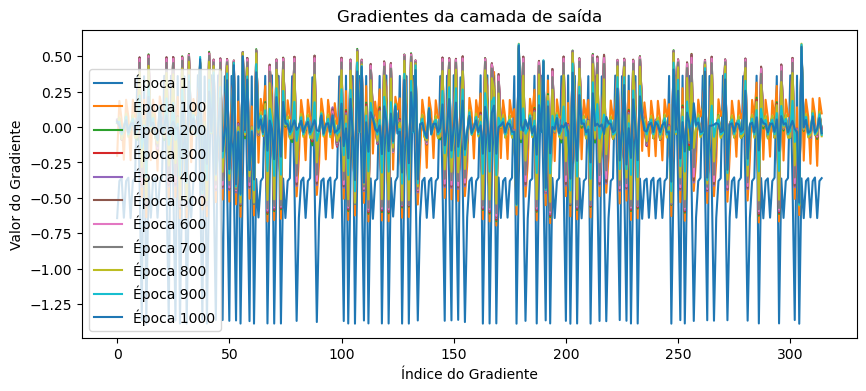

In [11]:
# Criação da MLP com Xavier e Regularização L2
input_tam = x_train.shape[1]
ocultas_tam = [2, 4]
output_tam = n_classes
mlpx = MLPX(input_tam, ocultas_tam, output_tam, lambda_l2=0.01)

# Treinamento da MLP com Xavier e Regularização L2
mlpx.train(x_train, y_train_one_hot, epochs=1000, lr=0.01)

# Fazendo previsões
y_pred = mlpx.predict(x_test)

y_pred_classe = np.argmax(y_pred, axis=1)
y_true_classe = np.argmax(y_test_one_hot, axis=1)

# Acurácia
accuracy = np.mean(y_pred_classe == y_true_classe)
print(f"Acurácia no conjunto de teste: {accuracy * 100:.2f}%")

# Plotando a curva de perda
mlpx.plot_loss()

# Plotando as ativações
mlpx.plot_activations()

# Plotando os gradientes
mlpx.plot_gradientes()

### Observação

A implementação do inicializador e do regulador melhora drasticamente a performance do modelo, tornando-o excelente para essa situação.

## Mudança na criação da MLPX

Modificar o número de camadas

Epoch 1, Loss: 1.429041558990904
Epoch 100, Loss: 2.8086561741098235
Epoch 200, Loss: 2.7582237962674956
Epoch 300, Loss: 2.7087749243801795
Epoch 400, Loss: 2.6602893276040844
Epoch 500, Loss: 2.612747231616042
Epoch 600, Loss: 2.566129310732394
Epoch 700, Loss: 2.520416679882472
Epoch 800, Loss: 2.4755908864484635
Epoch 900, Loss: 2.4316339019848363
Epoch 1000, Loss: 2.388528113831608
Acurácia no conjunto de teste: 20.00%


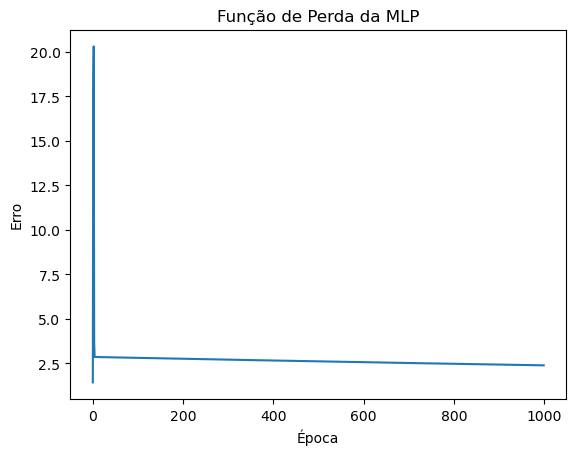

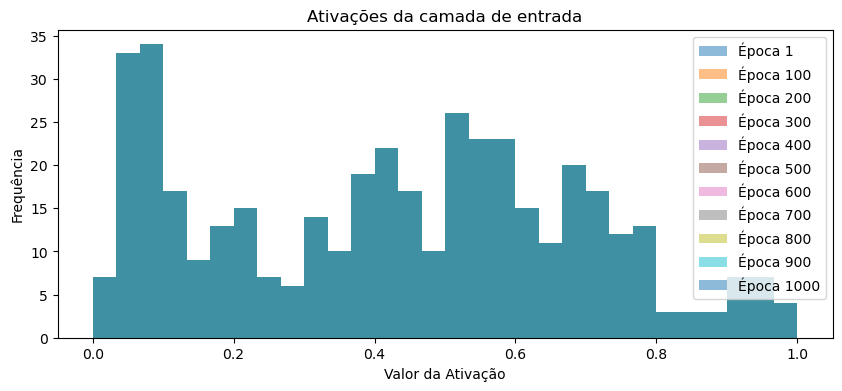

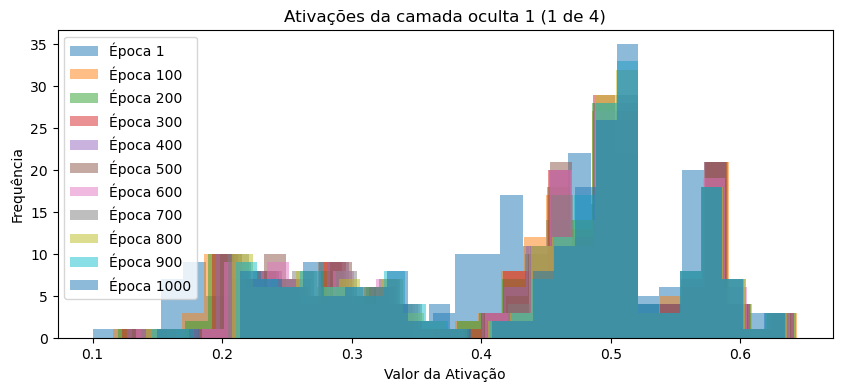

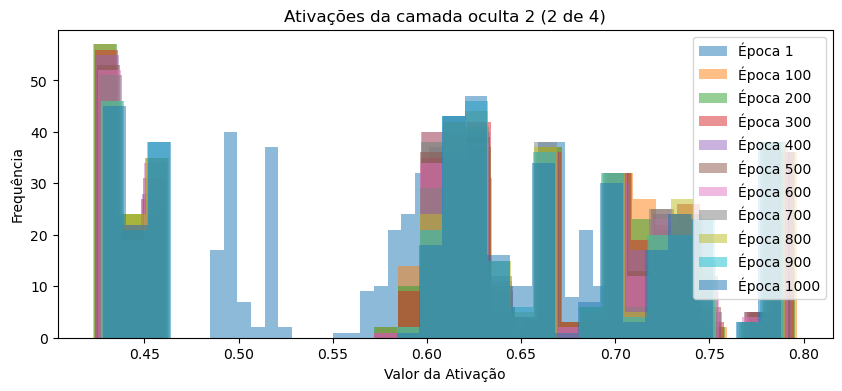

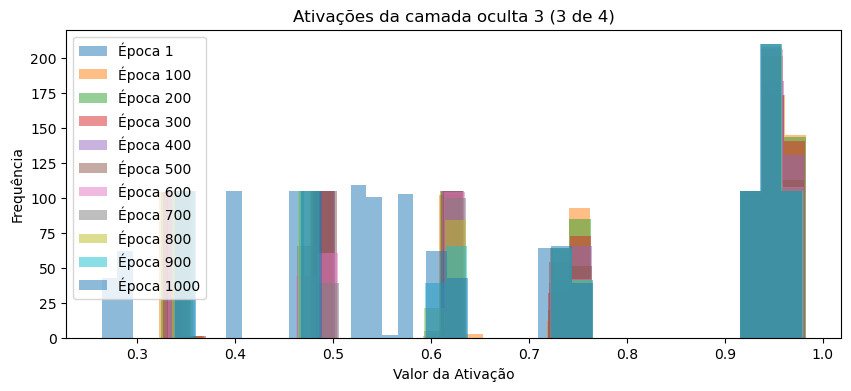

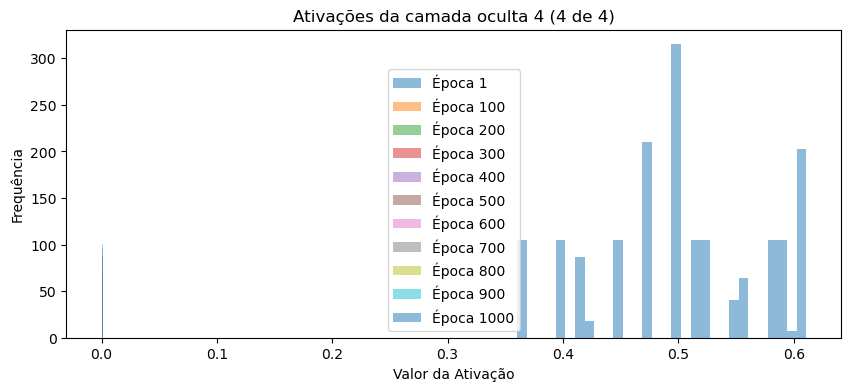

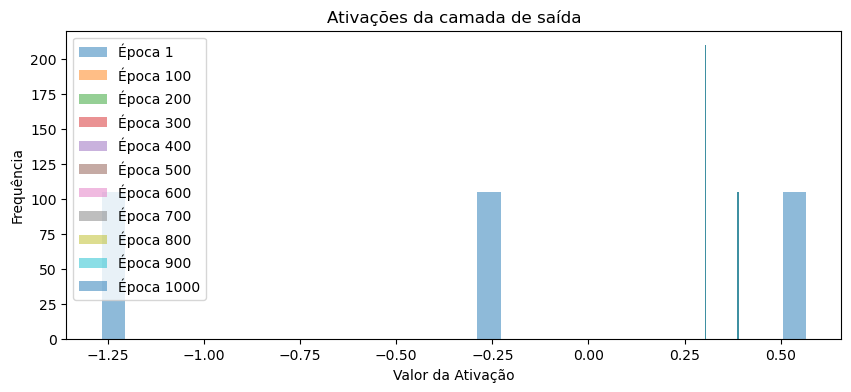

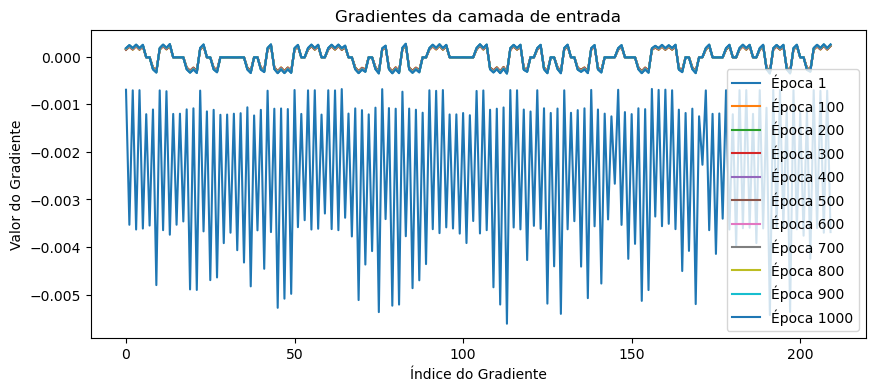

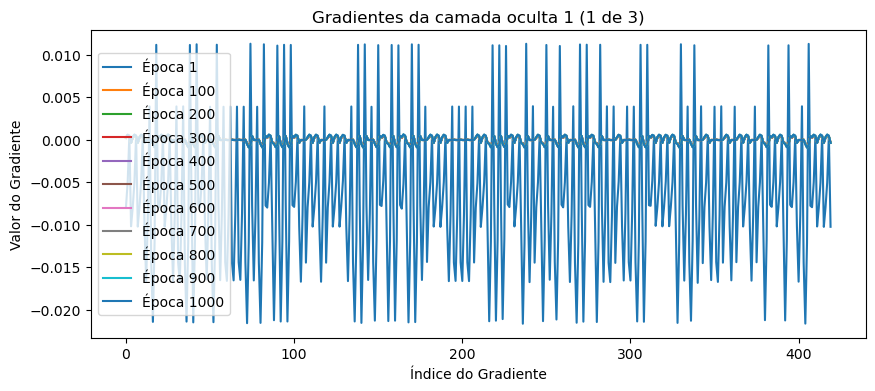

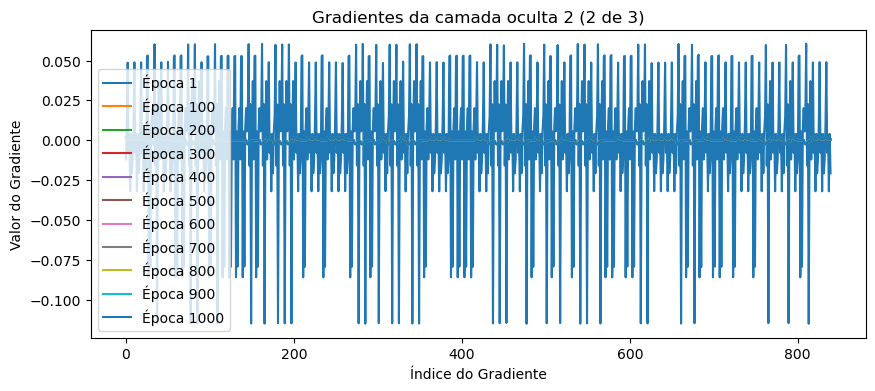

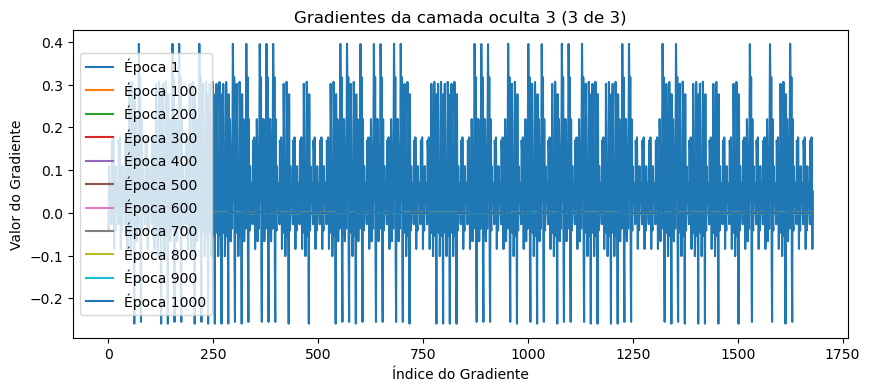

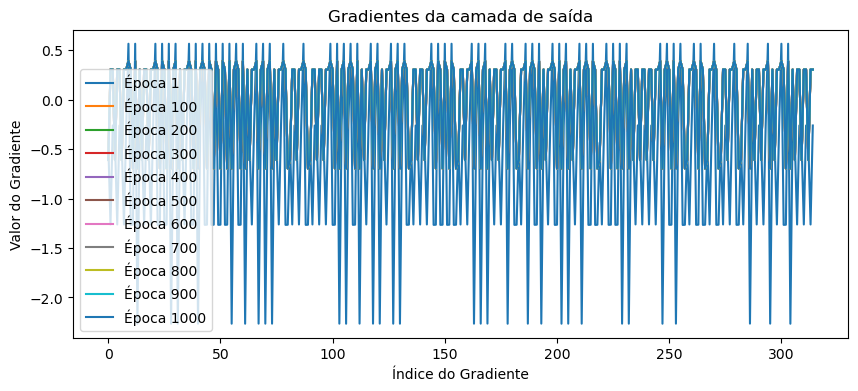

In [12]:
# Criação da MLP com Xavier e Regularização L2
input_tam = x_train.shape[1]
ocultas_tam = [2, 4, 8, 16]
output_tam = n_classes
mlpx = MLPX(input_tam, ocultas_tam, output_tam, lambda_l2=0.01)

# Treinamento da MLP com Xavier e Regularização L2
mlpx.train(x_train, y_train_one_hot, epochs=1000, lr=0.01)

# Fazendo previsões
y_pred = mlpx.predict(x_test)

y_pred_classe = np.argmax(y_pred, axis=1)
y_true_classe = np.argmax(y_test_one_hot, axis=1)

# Acurácia
accuracy = np.mean(y_pred_classe == y_true_classe)
print(f"Acurácia no conjunto de teste: {accuracy * 100:.2f}%")

# Plotando a curva de perda
mlpx.plot_loss()

# Plotando as ativações
mlpx.plot_activations()

# Plotando os gradientes
mlpx.plot_gradientes()

### Observação

O aumento do número de camadas reduz drasticamente a performance do modelo, provavelmente devido a variação do gradiente.

# Avaliação do Modelo

Avaliar a performance do modelo (`MLPX`) para Regressão e Classificação Binária

Ajustes

In [13]:
# Definição da MLP com Xavier e Regularização L2
class MLPXB:
    # Inicialização da MLP
    def __init__(self, input_tam, ocultas_tam, output_tam, lambda_l2 = 0.01):
        self.layers = len(ocultas_tam) + 1
        self.weights = []
        self.biases = []
        self.lossH = []
        self.gradientes = []
        self.activations = []
        self.lambda_l2 = lambda_l2

        # Inicialização dos pesos e bias usando Xavier
        layers_tam = [input_tam] + ocultas_tam + [output_tam]
        for i in range(self.layers):
            self.weights.append(xavier_init((layers_tam[i], layers_tam[i + 1])))
            self.biases.append(np.zeros((1, layers_tam[i + 1])))
    
    # Forward pass
    def forward(self, x):
        self.a = [x]
        self.z = []

        for i in range(self.layers):
            # z = a * w + b
            self.z.append(np.dot(self.a[i], self.weights[i]) + self.biases[i])
            
            # Aplicações das funções de ativação
            if i == self.layers - 1:
                # Última camada é linear
                self.a.append(linear(self.z[i]))
            else:
                # Camadas ocultas são sigmoid
                self.a.append(sigmoid(self.z[i]))
        
        return self.a[-1]
    
    # Backward pass (gradiente descendente)
    def backward(self, x, y, lr):
        # Cálculo do erro na última camada
        error = self.a[-1] - y.reshape(-1, 1) # Adicionado reshape
        gradientes = [error * linear_derivative(self.a[-1])]

        # Backpropagation das camadas ocultas
        for i in range(self.layers - 1, 0, -1):
            error = np.dot(gradientes[0], self.weights[i].T)
            gradientes.insert(0, error * sigmoid_derivative(self.a[i]))

        # Atualização dos pesos e bias
        for i in range(self.layers):
            self.weights[i] -= lr * (np.dot(self.a[i].T, gradientes[i]) + self.lambda_l2 * self.weights[i])
            self.biases[i] -= lr * np.sum(gradientes[i], axis=0, keepdims=True)
        
        return gradientes
    
    # Treinamento da MLP
    def train(self, x, y, epochs, lr):
        for epoch in range(epochs):
            output = self.forward(x)

            # Sinalizador de NaN ou Inf
            if np.any(np.isnan(output)) or np.any(np.isinf(output)):
                print(f"NaN ou Inf detectado na época {epoch}")
                break

            loss = np.mean((output - y) ** 2) + self.lambda_l2 * sum(np.sum(w ** 2) for w in self.weights)
            self.lossH.append(loss)
            gradientes = self.backward(x, y, lr)

            if (epoch + 1) % 100 == 0 or epoch == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss}")
                self.gradientes.append(gradientes)
                self.activations.append([a.copy() for a in self.a])
    
    # Predição
    def predict(self, x):
        return self.forward(x)
    
    # Plotar o gráfico da função de perda
    def plot_loss(self):
        plt.plot(self.lossH)
        plt.xlabel("Época")
        plt.ylabel("Erro")
        plt.title("Função de Perda da MLP")
        plt.show()
    
    # Plotar ativações
    def plot_activations(self):
        if not self.activations:
            print("Nenhuma ativação armazenada.")
            return
        num_layers = len(self.activations[0])
        for i in range(num_layers):
            plt.figure(figsize=(10, 4))
            for epoch in range(len(self.activations)):
                if epoch == 0:
                    plt.hist(self.activations[epoch][i].flatten(), bins=30, alpha=0.5, label=f'Época {epoch + 1}')
                else:
                    plt.hist(self.activations[epoch][i].flatten(), bins=30, alpha=0.5, label=f'Época {epoch * 100}')
            if i == 0:
                plt.title(f'Ativações da camada de entrada')
            elif i == num_layers - 1:
                plt.title(f'Ativações da camada de saída')
            else:
                plt.title(f'Ativações da camada oculta {i} ({i} de {num_layers - 2})')
            plt.xlabel('Valor da Ativação')
            plt.ylabel('Frequência')
            plt.legend()
            plt.show()

    # Plotar gradientes
    def plot_gradientes(self):
        if not self.gradientes:
            print("Nenhum gradiente armazenado.")
            return
        num_layers = len(self.gradientes[0])
        for i in range(num_layers):
            plt.figure(figsize=(10, 4))
            for epoch in range(len(self.gradientes)):
                if epoch == 0:
                    plt.plot(self.gradientes[epoch][i].flatten(), label=f'Época {epoch + 1}')
                else:
                    plt.plot(self.gradientes[epoch][i].flatten(), label=f'Época {epoch * 100}')
            if i == 0:
                plt.title(f'Gradientes da camada de entrada')
            elif i == num_layers - 1:
                plt.title(f'Gradientes da camada de saída')
            else:
                plt.title(f'Gradientes da camada oculta {i} ({i} de {num_layers - 2})')
            plt.xlabel('Índice do Gradiente')
            plt.ylabel('Valor do Gradiente')
            plt.legend()
            plt.show()

Importar datasets

In [14]:
import pandas as pd

# Importar dataset
datasetCB = np.loadtxt("../Data/wdbc.data", delimiter=",", dtype=str)
datasetWR = pd.read_csv("../Data/winequality-red.csv", delimiter=";")

# Ignorar os Warnings
import warnings
warnings.filterwarnings('ignore')

## Classificação Binária com o dataset Brest Cancer Wisconsin

In [15]:
# Separar os dados em features (colunas 2 a 31) e classes (coluna 1)
x = datasetCB[:, 2:].astype(float)
y = datasetCB[:, 1]

# Convertendo as classes para valores numéricos
y = np.where(y == "M", 1, 0)

# Normalizando os dados
x_min = x.min(axis=0)
x_max = x.max(axis=0)
x_normalized = (x - x_min) / (x_max - x_min)

# Dividindo o dataset em treino e teste
np.random.seed(8)
indices = np.arange(x_normalized.shape[0])
np.random.shuffle(indices)

# Separando 70% dos dados para treino e 30% para teste
train_size = int(0.7 * x_normalized.shape[0])
train_indices, test_indices = indices[:train_size], indices[train_size:]

x_train, y_train = x_normalized[train_indices], y[train_indices]
x_test, y_test = x_normalized[test_indices], y[test_indices]

# Criando a MLP com Xavier e Regularização L2
input_tam = x_train.shape[1]
ocultas_tam = [2, 4]
output_tam = 1
mlpxb = MLPXB(input_tam, ocultas_tam, output_tam, lambda_l2=0.01)

# Treinamento da MLP com Xavier e Regularização L2
mlpxb.train(x_train, y_train, epochs=1000, lr=0.001)

# Fazendo previsões
y_pred = mlpxb.predict(x_test)

# Convertendo as previsões para valores binários
y_pred = np.where(y_pred >= 0.5, 1, 0)

# Acurácia
accuracy = np.mean(y_pred.flatten() == y_test)
print(f"Acurácia no conjunto de teste: {accuracy * 100:.2f}%")

# Avaliando o modelo
mse = np.mean((y_pred.flatten() - y_test) ** 2)
print(f"MSE: {mse}")

Epoch 1, Loss: 0.3367276204274401
Epoch 100, Loss: 0.341761054745073
Epoch 200, Loss: 0.3647138815715391
Epoch 300, Loss: 0.4456407749309257
Epoch 400, Loss: 0.5933594724457392
Epoch 500, Loss: 0.6623873938023546
Epoch 600, Loss: 0.6793847911061998
Epoch 700, Loss: 0.6861206707864012
Epoch 800, Loss: 0.6908987988191349
Epoch 900, Loss: 0.6950131555112116
Epoch 1000, Loss: 0.6987188016775538
Acurácia no conjunto de teste: 96.49%
MSE: 0.03508771929824561


### Observação

Ao modificar a taxa de aprendizado, o modelo apresentou uma performance excelente

## Regressão com o dataset Wine Quality Red

In [16]:
# Separar os dados em features e target
x = datasetWR.iloc[:, :-1].values
y = datasetWR.iloc[:, -1].values

# Normalizando os dados
x_min = x.min(axis=0)
x_max = x.max(axis=0)
x_normalized = (x - x_min) / (x_max - x_min)

# Dividindo o dataset em treino e teste
np.random.seed(8)
indices = np.arange(x_normalized.shape[0])
np.random.shuffle(indices)

# Separando 70% dos dados para treino e 30% para teste
train_size = int(0.7 * x_normalized.shape[0])
train_indices, test_indices = indices[:train_size], indices[train_size:]

x_train, y_train = x_normalized[train_indices], y[train_indices]
x_test, y_test = x_normalized[test_indices], y[test_indices]

# Criando a MLP com Xavier e Regularização L2
input_tam = x_train.shape[1]
ocultas_tam = [2, 4]
output_tam = 1
mlpxb = MLPXB(input_tam, ocultas_tam, output_tam, lambda_l2=0.01)

# Treinamento da MLP com Xavier e Regularização L2
mlpxb.train(x_train, y_train, epochs=1000, lr=0.001)

# Fazendo previsões
y_pred = mlpxb.predict(x_test)

# Avaliação do modelo
mse = np.mean((y_pred.flatten() - y_test) ** 2)
print(f"Erro quadrático médio no conjunto de teste: {mse}")


Epoch 1, Loss: 39.88265664914912
Epoch 100, Loss: 1.2798295019511687
Epoch 200, Loss: 1.278686256838423
Epoch 300, Loss: 1.2776848430692818
Epoch 400, Loss: 1.2768587823933815
Epoch 500, Loss: 1.2762671728705464
Epoch 600, Loss: 1.2760155452678899
Epoch 700, Loss: 1.2763043652128274
Epoch 800, Loss: 1.2775576873244183
Epoch 900, Loss: 1.2808381897901202
Epoch 1000, Loss: 1.2896450563329502
Erro quadrático médio no conjunto de teste: 0.6401274751603361


### Observação

Após ajustar a taxa de aprendizado, a regressão apresentou um erro quadrático médio bem baixo e aceitável, mostrando uma boa performance do modelo.

# Conclusão

- A Inicialização de Xavier estabilizou o treinamento e evitou problemas de Explosão ou Desaparecimento do Gradiente;
- A Regularização L2 previniu o overfitting;
- A taxa de aprendizado mais adequada foi 0.01 para o dataset Iris e 0.001 para os datasets da Avaliação;
- O aumento do número de camadas paras esses datasets não se mostrou muito necessário ou eficaz, apenas 2 camadas com 2 e 4 neurônios se mostrou suficiente;

A MLP foi devidamente implementada com NumPy e dessa forma fica fácil modificar e entender como os hiperparâmetros agem no modelo. Ficou claro também a importância de uma boa inicialização, regularização e normalização dos dados (sem ela, não seria possível processar os datasets).